### What gives concrete its strength

Sreekanth Reddy Sajjala


Concrete is the world's most widely used material. Its mainly composed of aggregates, fillers, water and cement, which is the main adhesive element. The variation in the quantity of these elements in concrete greatly effects its physical properties, carbon footprint and cost. For maximum strength, it would make sense to use a ratio where as much cement is used along with the appropriate amount of water used but this would make it economicaly unfeasible and very detrimental to the environment because of cement prodution's large carbon footprint. Aggregates help to fill volume after a certain strength is reached while fillers help reduce cost of the mixture while also contributing to the strength. In this report, we investigate how the compressive strength of the concrete changes with the quantities of these elements. We also look into the difference between coarse and fine aggeragates along with the effect of slag and fly ash as fillers.

The reason this is an interesting analysis is because by being able to predict the strength of conrete we will be able to optimize the amount of filler and aggregate used thereby saving a lot in costs. The relationship between the composition and the strength of the concreteis highly non linear due to the variety of chemical compounds present in cement and the physcial formation of alite and belite crystals within the concrete.



#### Importing the requried packages

In [1]:
import numpy as np
from jax import jit
import numpy.random as npr
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
from tqdm import tqdm_notebook as tqdmn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

%matplotlib inline

import pandas as pd
#import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import utils
from utils import decorate
import matplotlib
from matplotlib.pyplot import *
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#### Dataset

We are using UCI's concrete compressive strength data repository which has a 1030 instances. The data is very clean with no missing values. 


Variable Information:

Given is the variable name, variable type, the measurement unit and a brief description. 
The concrete compressive strength is the regression problem. The order of this listing 
corresponds to the order of numerals along the rows of the database. 

Name -- Data Type -- Measurement -- Description

All the components are quantitative and have the same units of kg in m3 mixture.
They are all input variables.

Cement (component 1)

Blast Furnace Slag (component 2)

Fly Ash (component 3) 

Water (component 4)

Superplasticizer (component 5) 

Coarse Aggregate (component 6) 

Fine Aggregate (component 7) 

Age is a quantitative variable which measures, in days, the time since the concrete was cast.

The output varible is the concrete's compressive strength. Its measured in mega pascals and is the only output variable.


In [2]:
df = pd.read_csv('/home/ssajjala/project3/Concrete_Data.csv')
def plot_with_error(category,title):
    age2=df[(df['Age']<10)]
    age3=df[(df['Age']>10) & (df['Age']<30)];
    age4=df[(df['Age']>30) & (df['Age']<100)];
    age5=df[(df['Age']>100) & (df['Age']<250)];
    age6=df[(df['Age']>250)];
    fig, ax = subplots()
    grouped6=age6.groupby(category)
    grouped2=age2.groupby(category)
    grouped3=age3.groupby(category)
    grouped4=age4.groupby(category)
    grouped5=age5.groupby(category)
    series2=grouped2['strength'].mean()
    series3=grouped3['strength'].mean()
    series4=grouped4['strength'].mean()
    series5=grouped5['strength'].mean()
    series6=grouped6['strength'].mean()
    err2=grouped2['strength'].sem()
    err3=grouped3['strength'].sem()
    err4=grouped4['strength'].sem()
    err5=grouped5['strength'].sem()
    err6=grouped6['strength'].sem()
    series2.plot(color='C2',yerr=err2)
    series3.plot(color='C3',yerr=err3)
    series4.plot(color='C4',yerr=err4)
    series5.plot(color='C5',yerr=err4)
    series6.plot(color='C6',yerr=err5)
    ax.legend(["20-30", "30-40", "40-50","50-60","60+"])
    plt.title(title)


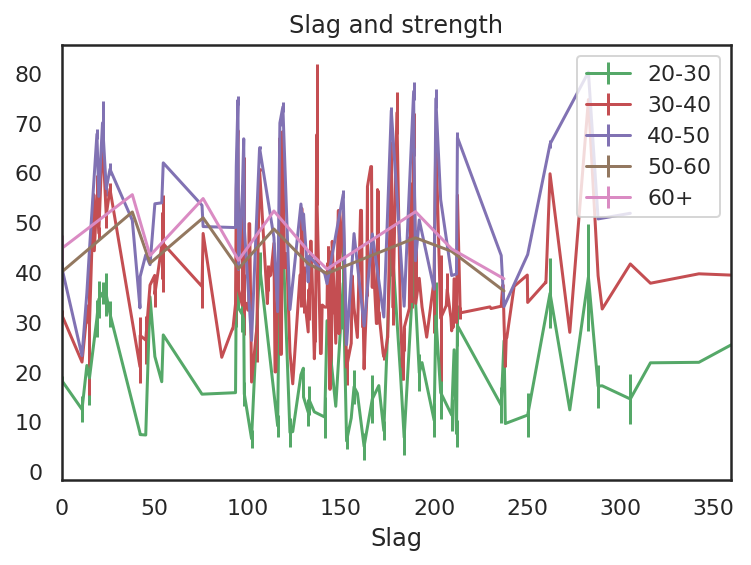

In [3]:
plot_with_error('Slag',"Slag and strength")

This plot seems like it does not contain any valuble information with all the noise and flat lines but it conveys something important about the dataset and concrete. It is not built as a test data set where different levels of slag are independently tested. Concrete is built to a specific strength and other variables are changed accordingly to achieve the same. The only variable which we can measure independently. is the Age of the pour as strength can be tested for the same mixture at different values of the variable.


In [4]:
df.head()

,Cement,Slag,Fly_Ash,Water,Superplasticizer,Coarse,Fine,Age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


 #### Splitting dataset into train and test data.

In [5]:
msk = np.random.rand(len(df)) < 0.8
train = df[msk]
test = df[~msk]
len(train)


811

In [6]:
list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

In [7]:
X_train = train.iloc[:, :8]
y_train = train.iloc[:, 8:]
x_test= test.iloc[:,8:]
y_test = test.iloc[:,8:]

In [8]:
def mse(y_true, y_pred):
    return np.mean(np.power(y_true - y_pred, 2))

# Calculate the mean squared error between 
#print(mse(y, y_est))
def mseloss(params, model, x, y):
    """
    :param flat_p: parameters to optimize
    :param unflattener: A function to unflatten the parameters into its original data structure.
    :param x: input data
    :param y: correct outputs
    """
    y_est = model(params, x)      # FITB
    return mse(y, y_est) 

from jax import grad

# `grad` as a function returns another function, let's call it `grad_func`.
# `grad_func`'s signature is identical to the original function passed into it.
# However, it's return statement returns an object of the same data structure
# as the first element passed into it, except now each element is a gradient scalar/tensor.
dmseloss = grad(mseloss)

### Basic linear regression

We shall first perfom basic linear regression to see how the strength of the cement shall vary with the various variables. This may not prove very useful as most of the relationships except for age are highly non linear

In [9]:

list(df)

['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age',
 'strength']

We shall be using all the variables as we don't know yet which have the most influence. We shall use the square of Age as the link between age and the strength of cement is a standardized topic which is non-linear and most tests used to grade cement measure the strength at fixed number of days since casting.  

In [10]:
import statsmodels.formula.api as smf
df['Age2']=df['Age']**2
model = smf.ols('strength ~  Slag +Cement + Fly_Ash+Water+Superplasticizer + Coarse +Fine+Age+Age2', data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               strength   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     328.4
Date:                Tue, 07 May 2019   Prob (F-statistic):          4.63e-294
Time:                        14:10:40   Log-Likelihood:                -3660.7
No. Observations:                1030   AIC:                             7341.
Df Residuals:                    1020   BIC:                             7391.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -3.7458     21.746     -0.172      0.863     -46.417      38.926
Slag                 0.0956      0.008     11.526      0.000       0.079       0.112
Cement               0.1136      0.007     16.359      0.000       0.100       0.127
Fly_Ash              0.0740      0.010      7.185      0.000       0.054       0.094
Water               -0.1739      0.033     -5.294      0.000      -0.238      -0.109
Superplasticizer     0.1993      0.076      2.607      0.009       0.049       0.349
Coarse               0.0082      0.008      1.064      0.287      -0.007       0.023
Fine                 0.0100      0.009      1.146      0.252      -0.007       0.027
Age                  0.3529      0.011     30.750      0.000       0.330       0.375
Age2                -0.0008   3.61e-05    -22.550      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       14.464   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               20.145
Skew:                           0.144   Prob(JB):                     4.22e-05
Kurtosis:                       3.621   Cond. No.                     1.73e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.73e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [11]:
df.Age.median()

28.0

No handles with labels found to put in legend.


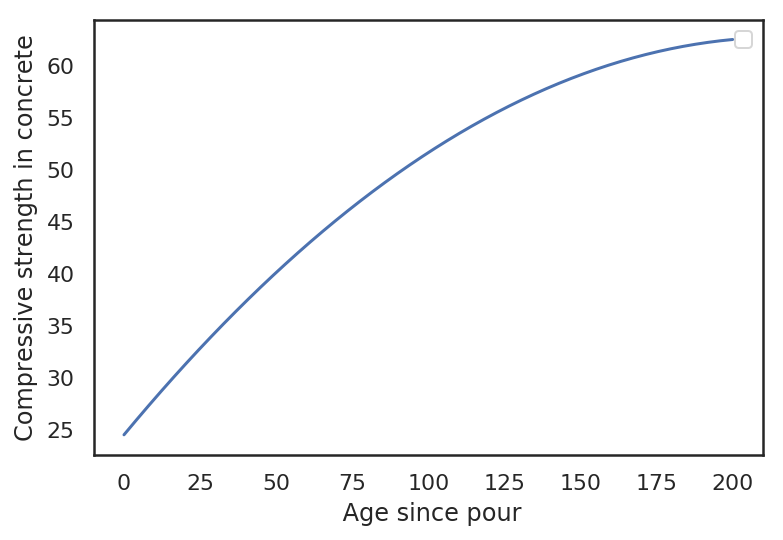

In [12]:

results = model.fit()
results.summary()
df2 = pd.DataFrame()
df2['Age'] = np.linspace(0, 200)
df2['Age2']=df2['Age']**2
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=280

df2['Coarse'] = 970
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()
pred12 = results.predict(df2)
plt.plot(df2['Age'], pred12)

plt.xlabel(' Age since pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();

We can clearly see the positive link between the strength of conrete and the number of days since its pour. Concrete reacts with the water to cure with time. We can see that the largest gain in strength is in the inital stages. The gain in strength then levels off but still continues to grow for years. Cement strength is usually measured by most standards at 28 days since casting


For some reason the model does not work when we try to change the explanatory variable from Age to anything else. I am unsure if I am ding something wrong with the code or if the model is unable to function.

No handles with labels found to put in legend.


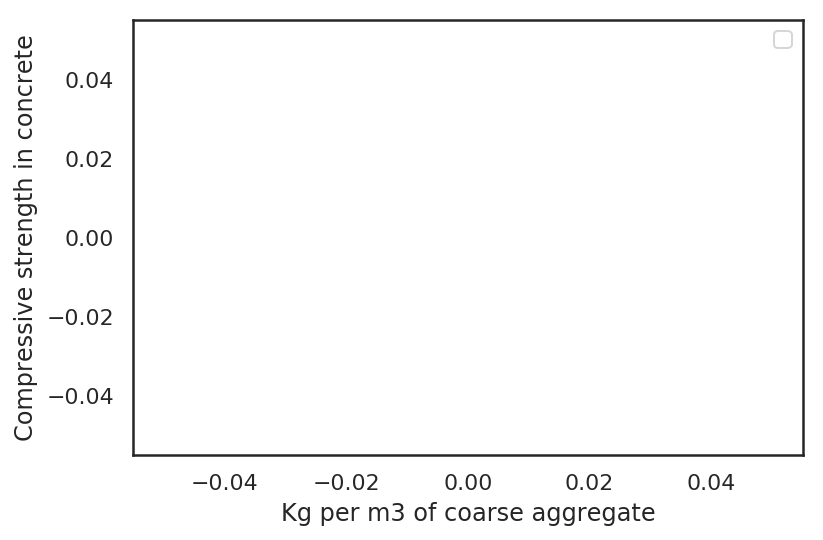

In [13]:
model = smf.ols('strength ~  Slag +Cement + Fly_Ash+Water+Superplasticizer + Coarse +Fine+Age', data=df)

df2 = pd.DataFrame()
df2['Age'] = 28
df2['Age2']=28**2
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=280

df2['Coarse'] = np.linspace(0, 200)
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()

results = model.fit()
results.summary()
pred13 = results.predict(df2)
plt.plot(df2['Coarse'], pred13)

plt.xlabel('Kg per m3 of coarse aggregate')
plt.ylabel('Compressive strength in concrete')
plt.legend();

Lets now try to run Lasso regression to undersatnd which variables effect the strength the most. 
I first satndardize the variables before dividing the dataset and running the regression.

In [14]:

xs_stand = df.sub(df.mean(1), axis=0).div(df.std(1), axis=0)
X = xs_stand.iloc[:, :8]
y = xs_stand.iloc[:, 8:]

Using the scipy function to create test and train sets.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, random_state=42)

In [16]:
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_train, y_train)

Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [17]:


lasso_pred = lasso.predict(X_test)
lasso.score(X_test, y_test)
list(X_test)


['Cement',
 'Slag',
 'Fly_Ash',
 'Water',
 'Superplasticizer',
 'Coarse',
 'Fine',
 'Age']

In [18]:
coef = lasso.coef_

In [19]:
names = X_train.columns

ValueError: x and y must have same first dimension, but have shapes (8,) and (2, 8)

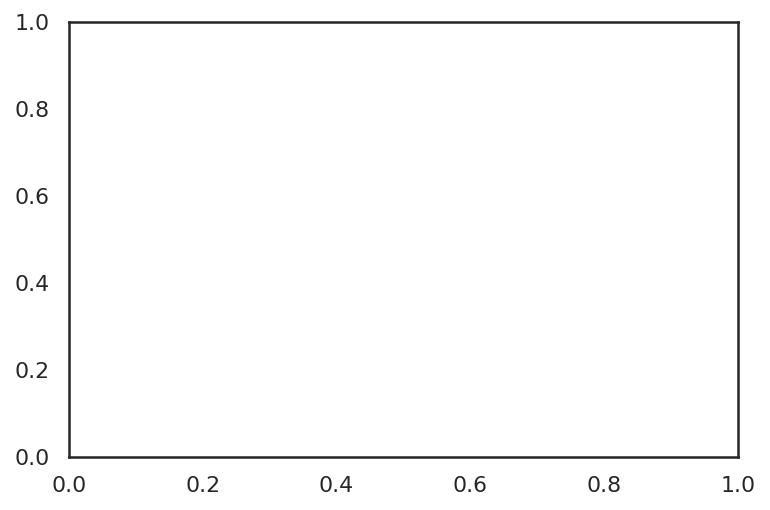

In [20]:


plt.plot(range(len(X_train.columns)), coef)
count = dict()
for i in range(len(coef)):
    if coef[i] > 0.02:
        count[i] = names[i]
    else:
        count[i] = ''

plt.xticks(range(len(count.keys())), count.values(), rotation=90)
plt.ylabel('Coefficients')
plt.show()



In [21]:
param_grid = {'alpha': np.arange(0.1,1,50)}

In [22]:
lasso = Lasso()
lasso_cv = GridSearchCV(lasso, param_grid, cv=5)
lasso_cv.fit(X, y)
lasso_cv.best_params_

{'alpha': 0.1}

In [23]:
lasso_cv.best_score_

-2.027272529089009

In [24]:
from sklearn import linear_model

In [25]:
reg = linear_model.LinearRegression()

In [26]:
reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [27]:

reg_pred = reg.predict(X_test)
reg.score(X_test, y_test)


0.9997070616217811

In [28]:
coef = reg.coef_
coef

array([[ 0.11346448,  0.07749585,  0.04239245, -0.17332687,  0.12385316,
         0.00571781,  0.01176529,  0.81083355],
       [-1.11346448, -1.07749585, -1.04239245, -0.82667313, -1.12385316,
        -1.00571781, -1.01176529, -1.81083355]])

In [29]:
names = X_train.columns

In [30]:
reg = linear_model.LinearRegression()
reg_cv = GridSearchCV(reg, param_grid, cv=5)


In [31]:
def standardize(self, df, label):
    """
    standardizes a series with name ``label'' within the pd.DataFrame
    ``df''.
    """
    df = df.copy(deep=True)
    series = df.loc[:, label]
    avg = series.mean()
    stdv = series.std()
    series_standardized = (series - avg)/ stdv
    return series_standardized

Now lets build a neural network and fit it our data. This seems useful to do as neural networks are great ways to explore non linear relationships between variables. 

Lets import all the required packages

In [32]:
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
#from xgboost import XGBRegressor

Using TensorFlow backend.


Now lets look at how the different variables correlated with each other. Its a nice visual which shall help us understand which variables have the most influence.

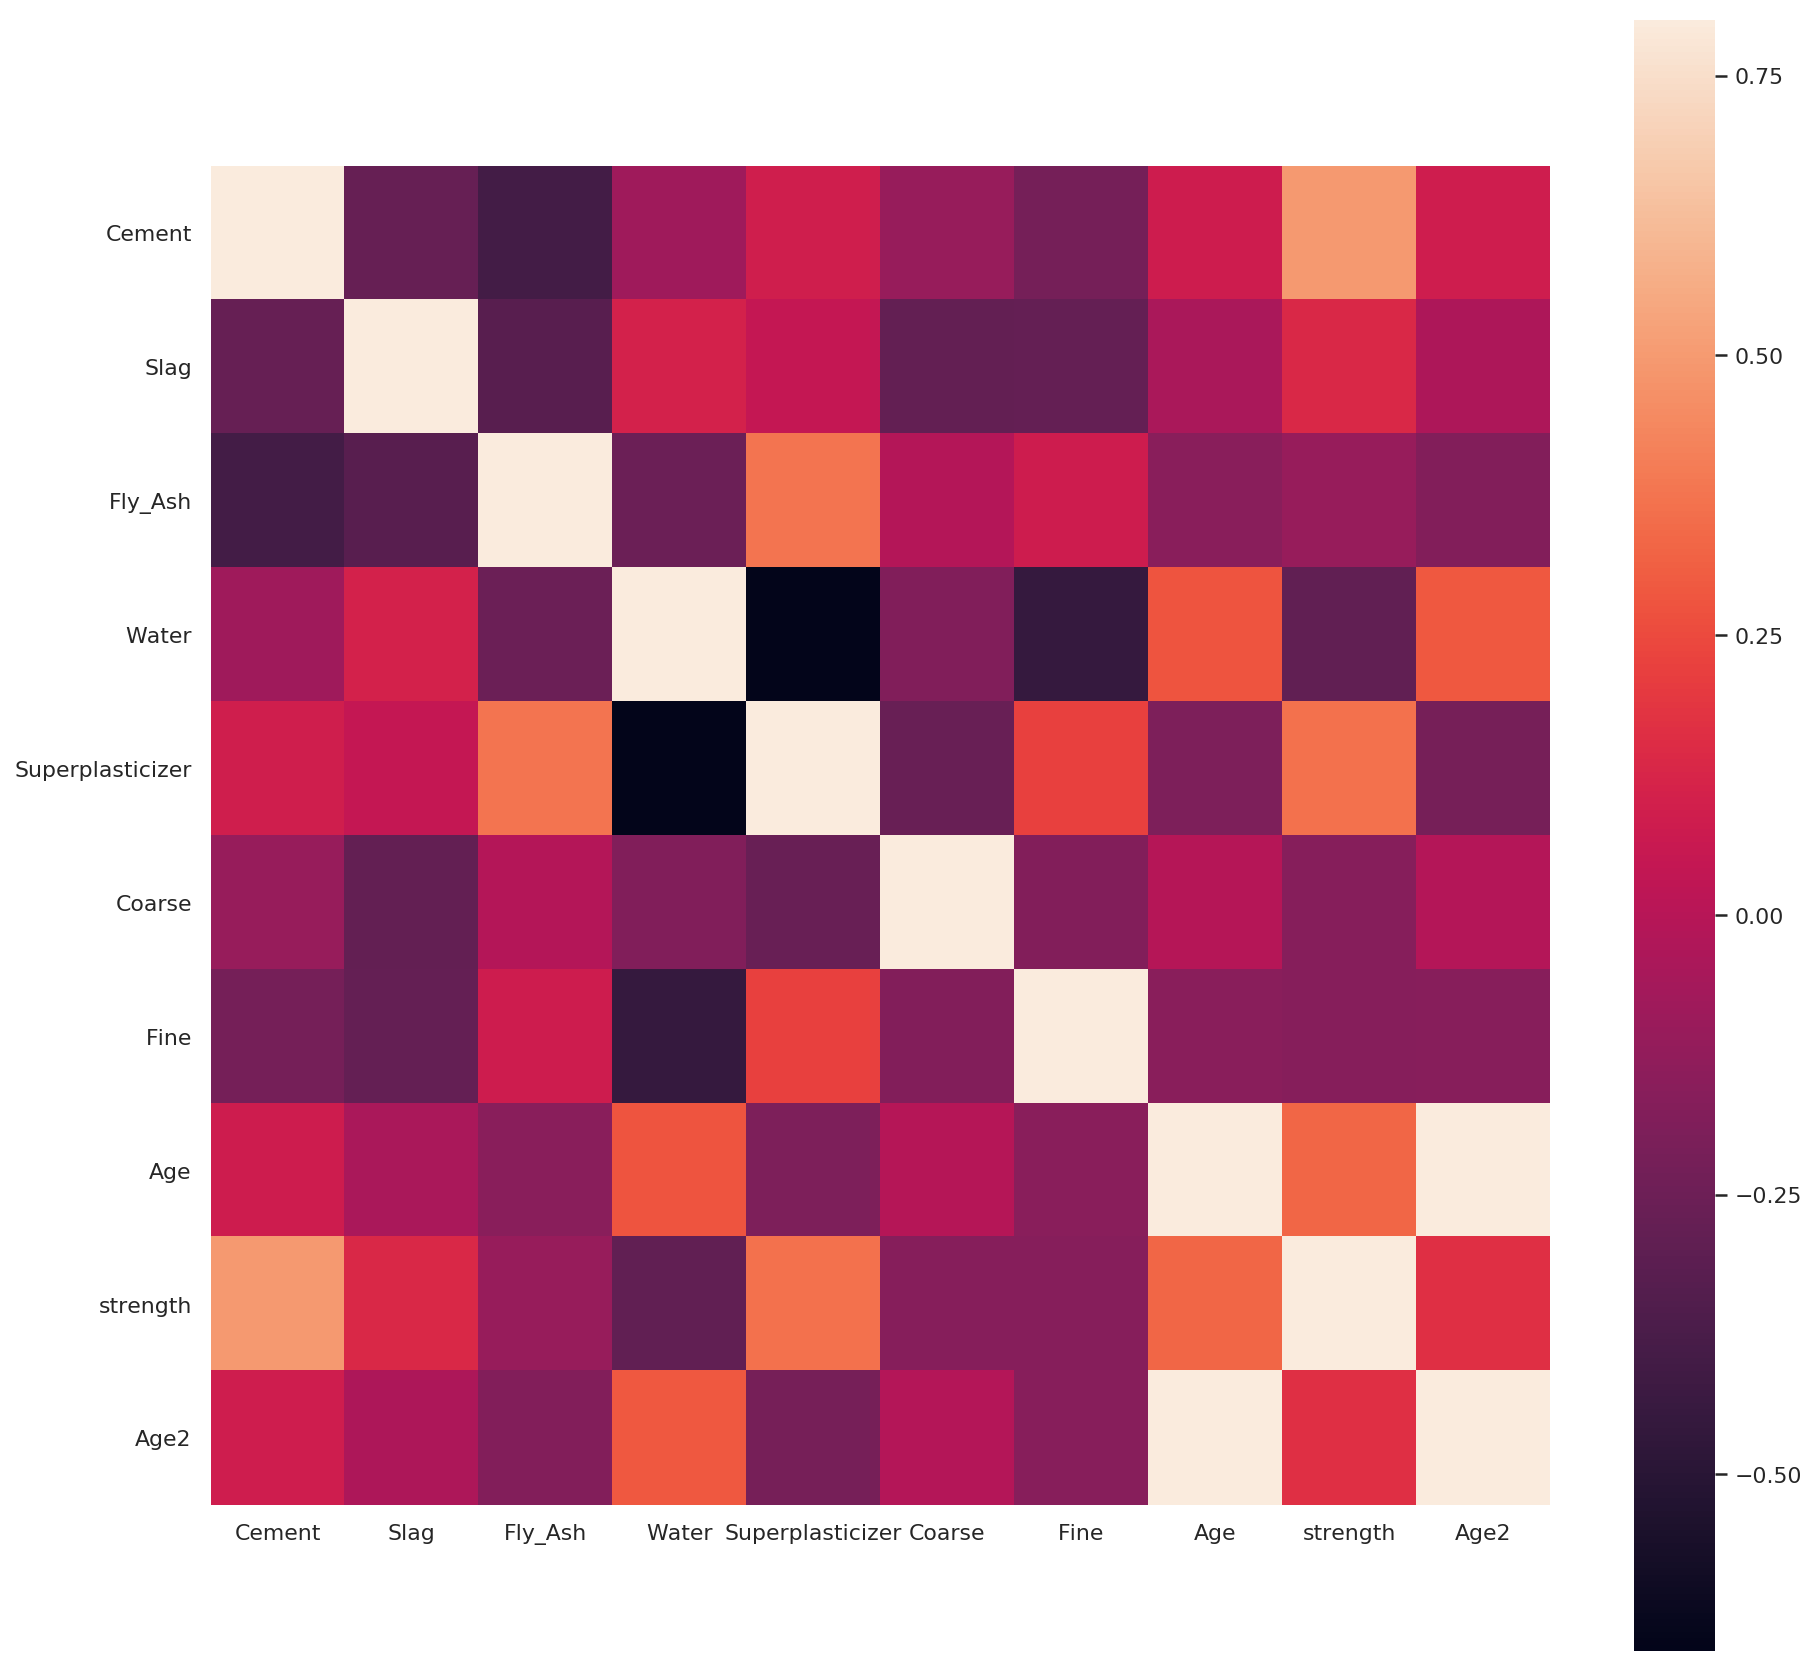

In [33]:
df.drop(columns=['Age2'])
C_mat = df.corr()
fig = plt.figure(figsize = (15,15))

sb.heatmap(C_mat, vmax = .8, square = True)
plt.show()

Lets build the Neural net. This is lifted from a template and is appropriate for a data set with < 20 numerical values and 1 numerical output.

In [34]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
NN_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 166,145
Trainable params: 166,145
Non-trainable params: 0
_________________________________________________________________


Lets set some checkpoints for the neural net. We shall be monitoing the loss value. We shall only saving the weight values where we see a decrease in report. The target variable is being set to the strength of the cement.

In [40]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]
train_data = train
target = train_data['strength'] 


Now lets fit the model to our data. We are running the thing for 2000 cycles.

In [41]:
history= NN_model.fit(train, target, epochs=1000, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Instructions for updating:
Use tf.cast instead.
Train on 648 samples, validate on 163 samples
Epoch 1/1000
648/648 [==============================] - 1s 1ms/step - loss: 2.0838 - mean_absolute_error: 2.0838 - val_loss: 0.3747 - val_mean_absolute_error: 0.3747

Epoch 00001: val_loss improved from inf to 0.37468, saving model to Weights-001--0.37468.hdf5
Epoch 2/1000
648/648 [==============================] - 0s 232us/step - loss: 0.9538 - mean_absolute_error: 0.9538 - val_loss: 0.3150 - val_mean_absolute_error: 0.3150

Epoch 00002: val_loss improved from 0.37468 to 0.31502, saving model to Weights-002--0.31502.hdf5
Epoch 3/1000
648/648 [==============================] - 0s 305us/step - loss: 0.5826 - mean_absolute_error: 0.5826 - val_loss: 0.7478 - val_mean_absolute_error: 0.7478

Epoch 00003: val_loss did not improve from 0.31502
Epoch 4/1000
648/648 [==============================] - 0s 268us/step - loss: 0.8773 - mean_absolute_error: 0.8773 - val_loss: 0.9112 - val_mean_absolute_erro

648/648 [==============================] - 0s 280us/step - loss: 0.6231 - mean_absolute_error: 0.6231 - val_loss: 1.0092 - val_mean_absolute_error: 1.0092

Epoch 00036: val_loss did not improve from 0.12910
Epoch 37/1000
648/648 [==============================] - 0s 227us/step - loss: 0.6196 - mean_absolute_error: 0.6196 - val_loss: 0.7920 - val_mean_absolute_error: 0.7920

Epoch 00037: val_loss did not improve from 0.12910
Epoch 38/1000
648/648 [==============================] - 0s 168us/step - loss: 0.6015 - mean_absolute_error: 0.6015 - val_loss: 1.0128 - val_mean_absolute_error: 1.0128

Epoch 00038: val_loss did not improve from 0.12910
Epoch 39/1000
648/648 [==============================] - 0s 281us/step - loss: 0.8683 - mean_absolute_error: 0.8683 - val_loss: 0.5622 - val_mean_absolute_error: 0.5622

Epoch 00039: val_loss did not improve from 0.12910
Epoch 40/1000
648/648 [==============================] - 0s 243us/step - loss: 0.4560 - mean_absolute_error: 0.4560 - val_loss: 0.

648/648 [==============================] - 0s 151us/step - loss: 1.3897 - mean_absolute_error: 1.3897 - val_loss: 0.4729 - val_mean_absolute_error: 0.4729

Epoch 00073: val_loss did not improve from 0.12910
Epoch 74/1000
648/648 [==============================] - 0s 177us/step - loss: 1.0189 - mean_absolute_error: 1.0189 - val_loss: 0.3514 - val_mean_absolute_error: 0.3514

Epoch 00074: val_loss did not improve from 0.12910
Epoch 75/1000
648/648 [==============================] - 0s 229us/step - loss: 0.5041 - mean_absolute_error: 0.5041 - val_loss: 0.5023 - val_mean_absolute_error: 0.5023

Epoch 00075: val_loss did not improve from 0.12910
Epoch 76/1000
648/648 [==============================] - 0s 204us/step - loss: 0.3313 - mean_absolute_error: 0.3313 - val_loss: 0.3420 - val_mean_absolute_error: 0.3420

Epoch 00076: val_loss did not improve from 0.12910
Epoch 77/1000
648/648 [==============================] - 0s 217us/step - loss: 0.6278 - mean_absolute_error: 0.6278 - val_loss: 1.

648/648 [==============================] - 0s 200us/step - loss: 0.4243 - mean_absolute_error: 0.4243 - val_loss: 0.2770 - val_mean_absolute_error: 0.2770

Epoch 00110: val_loss did not improve from 0.11812
Epoch 111/1000
648/648 [==============================] - 0s 171us/step - loss: 0.3321 - mean_absolute_error: 0.3321 - val_loss: 0.8038 - val_mean_absolute_error: 0.8038

Epoch 00111: val_loss did not improve from 0.11812
Epoch 112/1000
648/648 [==============================] - 0s 289us/step - loss: 0.8515 - mean_absolute_error: 0.8515 - val_loss: 0.8705 - val_mean_absolute_error: 0.8705

Epoch 00112: val_loss did not improve from 0.11812
Epoch 113/1000
648/648 [==============================] - 0s 382us/step - loss: 0.7778 - mean_absolute_error: 0.7778 - val_loss: 0.9972 - val_mean_absolute_error: 0.9972

Epoch 00113: val_loss did not improve from 0.11812
Epoch 114/1000
648/648 [==============================] - 0s 237us/step - loss: 0.5773 - mean_absolute_error: 0.5773 - val_loss

648/648 [==============================] - 0s 233us/step - loss: 0.3846 - mean_absolute_error: 0.3846 - val_loss: 0.1579 - val_mean_absolute_error: 0.1579

Epoch 00147: val_loss did not improve from 0.11812
Epoch 148/1000
648/648 [==============================] - 0s 183us/step - loss: 0.5161 - mean_absolute_error: 0.5161 - val_loss: 0.7206 - val_mean_absolute_error: 0.7206

Epoch 00148: val_loss did not improve from 0.11812
Epoch 149/1000
648/648 [==============================] - 0s 228us/step - loss: 0.3242 - mean_absolute_error: 0.3242 - val_loss: 0.2039 - val_mean_absolute_error: 0.2039

Epoch 00149: val_loss did not improve from 0.11812
Epoch 150/1000
648/648 [==============================] - 0s 235us/step - loss: 0.5769 - mean_absolute_error: 0.5769 - val_loss: 0.5748 - val_mean_absolute_error: 0.5748

Epoch 00150: val_loss did not improve from 0.11812
Epoch 151/1000
648/648 [==============================] - 0s 242us/step - loss: 0.7421 - mean_absolute_error: 0.7421 - val_loss

648/648 [==============================] - 0s 343us/step - loss: 0.4930 - mean_absolute_error: 0.4930 - val_loss: 0.1151 - val_mean_absolute_error: 0.1151

Epoch 00184: val_loss improved from 0.11812 to 0.11508, saving model to Weights-184--0.11508.hdf5
Epoch 185/1000
648/648 [==============================] - 0s 375us/step - loss: 0.3047 - mean_absolute_error: 0.3047 - val_loss: 0.8801 - val_mean_absolute_error: 0.8801

Epoch 00185: val_loss did not improve from 0.11508
Epoch 186/1000
648/648 [==============================] - 0s 300us/step - loss: 0.8030 - mean_absolute_error: 0.8030 - val_loss: 0.9390 - val_mean_absolute_error: 0.9390

Epoch 00186: val_loss did not improve from 0.11508
Epoch 187/1000
648/648 [==============================] - 0s 530us/step - loss: 0.5773 - mean_absolute_error: 0.5773 - val_loss: 0.5989 - val_mean_absolute_error: 0.5989

Epoch 00187: val_loss did not improve from 0.11508
Epoch 188/1000
648/648 [==============================] - 0s 344us/step - loss: 


Epoch 00220: val_loss did not improve from 0.11508
Epoch 221/1000
648/648 [==============================] - 0s 233us/step - loss: 0.4332 - mean_absolute_error: 0.4332 - val_loss: 0.2790 - val_mean_absolute_error: 0.2790

Epoch 00221: val_loss did not improve from 0.11508
Epoch 222/1000
648/648 [==============================] - 0s 210us/step - loss: 0.4215 - mean_absolute_error: 0.4215 - val_loss: 0.1685 - val_mean_absolute_error: 0.1685

Epoch 00222: val_loss did not improve from 0.11508
Epoch 223/1000
648/648 [==============================] - 0s 213us/step - loss: 0.3578 - mean_absolute_error: 0.3578 - val_loss: 0.9007 - val_mean_absolute_error: 0.9007

Epoch 00223: val_loss did not improve from 0.11508
Epoch 224/1000
648/648 [==============================] - 0s 210us/step - loss: 0.7002 - mean_absolute_error: 0.7002 - val_loss: 1.5215 - val_mean_absolute_error: 1.5215

Epoch 00224: val_loss did not improve from 0.11508
Epoch 225/1000
648/648 [==============================] - 0s


Epoch 00257: val_loss did not improve from 0.11508
Epoch 258/1000
648/648 [==============================] - 0s 234us/step - loss: 0.8882 - mean_absolute_error: 0.8882 - val_loss: 1.0584 - val_mean_absolute_error: 1.0584

Epoch 00258: val_loss did not improve from 0.11508
Epoch 259/1000
648/648 [==============================] - 0s 175us/step - loss: 0.8948 - mean_absolute_error: 0.8948 - val_loss: 2.0382 - val_mean_absolute_error: 2.0382

Epoch 00259: val_loss did not improve from 0.11508
Epoch 260/1000
648/648 [==============================] - 0s 268us/step - loss: 1.1938 - mean_absolute_error: 1.1938 - val_loss: 0.3800 - val_mean_absolute_error: 0.3800

Epoch 00260: val_loss did not improve from 0.11508
Epoch 261/1000
648/648 [==============================] - 0s 299us/step - loss: 0.4094 - mean_absolute_error: 0.4094 - val_loss: 0.2990 - val_mean_absolute_error: 0.2990

Epoch 00261: val_loss did not improve from 0.11508
Epoch 262/1000
648/648 [==============================] - 0s


Epoch 00294: val_loss did not improve from 0.11508
Epoch 295/1000
648/648 [==============================] - 0s 153us/step - loss: 0.6972 - mean_absolute_error: 0.6972 - val_loss: 0.3233 - val_mean_absolute_error: 0.3233

Epoch 00295: val_loss did not improve from 0.11508
Epoch 296/1000
648/648 [==============================] - 0s 162us/step - loss: 0.6594 - mean_absolute_error: 0.6594 - val_loss: 0.7600 - val_mean_absolute_error: 0.7600

Epoch 00296: val_loss did not improve from 0.11508
Epoch 297/1000
648/648 [==============================] - 0s 197us/step - loss: 0.7683 - mean_absolute_error: 0.7683 - val_loss: 0.6054 - val_mean_absolute_error: 0.6054

Epoch 00297: val_loss did not improve from 0.11508
Epoch 298/1000
648/648 [==============================] - 0s 243us/step - loss: 0.5214 - mean_absolute_error: 0.5214 - val_loss: 0.2388 - val_mean_absolute_error: 0.2388

Epoch 00298: val_loss did not improve from 0.11508
Epoch 299/1000
648/648 [==============================] - 0s

648/648 [==============================] - 0s 264us/step - loss: 0.7956 - mean_absolute_error: 0.7956 - val_loss: 0.6970 - val_mean_absolute_error: 0.6970

Epoch 00331: val_loss did not improve from 0.08934
Epoch 332/1000
648/648 [==============================] - 0s 169us/step - loss: 0.6870 - mean_absolute_error: 0.6870 - val_loss: 1.1531 - val_mean_absolute_error: 1.1531

Epoch 00332: val_loss did not improve from 0.08934
Epoch 333/1000
648/648 [==============================] - 0s 251us/step - loss: 0.7734 - mean_absolute_error: 0.7734 - val_loss: 0.6466 - val_mean_absolute_error: 0.6466

Epoch 00333: val_loss did not improve from 0.08934
Epoch 334/1000
648/648 [==============================] - 0s 215us/step - loss: 0.4031 - mean_absolute_error: 0.4031 - val_loss: 0.5701 - val_mean_absolute_error: 0.5701

Epoch 00334: val_loss did not improve from 0.08934
Epoch 335/1000
648/648 [==============================] - 0s 294us/step - loss: 0.6753 - mean_absolute_error: 0.6753 - val_loss

648/648 [==============================] - 0s 291us/step - loss: 0.4114 - mean_absolute_error: 0.4114 - val_loss: 0.3182 - val_mean_absolute_error: 0.3182

Epoch 00368: val_loss did not improve from 0.08934
Epoch 369/1000
648/648 [==============================] - 0s 283us/step - loss: 0.3639 - mean_absolute_error: 0.3639 - val_loss: 0.2458 - val_mean_absolute_error: 0.2458

Epoch 00369: val_loss did not improve from 0.08934
Epoch 370/1000
648/648 [==============================] - 0s 299us/step - loss: 0.3409 - mean_absolute_error: 0.3409 - val_loss: 0.3218 - val_mean_absolute_error: 0.3218

Epoch 00370: val_loss did not improve from 0.08934
Epoch 371/1000
648/648 [==============================] - 0s 339us/step - loss: 0.5123 - mean_absolute_error: 0.5123 - val_loss: 0.6225 - val_mean_absolute_error: 0.6225

Epoch 00371: val_loss did not improve from 0.08934
Epoch 372/1000
648/648 [==============================] - 0s 366us/step - loss: 0.5541 - mean_absolute_error: 0.5541 - val_loss

648/648 [==============================] - 0s 194us/step - loss: 0.6620 - mean_absolute_error: 0.6620 - val_loss: 0.1672 - val_mean_absolute_error: 0.1672

Epoch 00405: val_loss did not improve from 0.08934
Epoch 406/1000
648/648 [==============================] - 0s 239us/step - loss: 0.1667 - mean_absolute_error: 0.1667 - val_loss: 0.3361 - val_mean_absolute_error: 0.3361

Epoch 00406: val_loss did not improve from 0.08934
Epoch 407/1000
648/648 [==============================] - 0s 302us/step - loss: 0.3305 - mean_absolute_error: 0.3305 - val_loss: 0.1121 - val_mean_absolute_error: 0.1121

Epoch 00407: val_loss did not improve from 0.08934
Epoch 408/1000
648/648 [==============================] - 0s 171us/step - loss: 0.4162 - mean_absolute_error: 0.4162 - val_loss: 0.4136 - val_mean_absolute_error: 0.4136

Epoch 00408: val_loss did not improve from 0.08934
Epoch 409/1000
648/648 [==============================] - 0s 152us/step - loss: 0.3909 - mean_absolute_error: 0.3909 - val_loss

648/648 [==============================] - 0s 155us/step - loss: 0.7353 - mean_absolute_error: 0.7353 - val_loss: 1.0152 - val_mean_absolute_error: 1.0152

Epoch 00442: val_loss did not improve from 0.08934
Epoch 443/1000
648/648 [==============================] - 0s 215us/step - loss: 0.4953 - mean_absolute_error: 0.4953 - val_loss: 0.4507 - val_mean_absolute_error: 0.4507

Epoch 00443: val_loss did not improve from 0.08934
Epoch 444/1000
648/648 [==============================] - 0s 188us/step - loss: 0.3867 - mean_absolute_error: 0.3867 - val_loss: 0.5759 - val_mean_absolute_error: 0.5759

Epoch 00444: val_loss did not improve from 0.08934
Epoch 445/1000
648/648 [==============================] - 0s 182us/step - loss: 0.3245 - mean_absolute_error: 0.3245 - val_loss: 0.3873 - val_mean_absolute_error: 0.3873

Epoch 00445: val_loss did not improve from 0.08934
Epoch 446/1000
648/648 [==============================] - 0s 232us/step - loss: 0.4275 - mean_absolute_error: 0.4275 - val_loss

648/648 [==============================] - 0s 157us/step - loss: 0.6554 - mean_absolute_error: 0.6554 - val_loss: 0.2118 - val_mean_absolute_error: 0.2118

Epoch 00479: val_loss did not improve from 0.08934
Epoch 480/1000
648/648 [==============================] - 0s 169us/step - loss: 0.6457 - mean_absolute_error: 0.6457 - val_loss: 0.1610 - val_mean_absolute_error: 0.1610

Epoch 00480: val_loss did not improve from 0.08934
Epoch 481/1000
648/648 [==============================] - 0s 188us/step - loss: 0.2425 - mean_absolute_error: 0.2425 - val_loss: 0.0923 - val_mean_absolute_error: 0.0923

Epoch 00481: val_loss did not improve from 0.08934
Epoch 482/1000
648/648 [==============================] - 0s 262us/step - loss: 0.3094 - mean_absolute_error: 0.3094 - val_loss: 0.2807 - val_mean_absolute_error: 0.2807

Epoch 00482: val_loss did not improve from 0.08934
Epoch 483/1000
648/648 [==============================] - 0s 207us/step - loss: 0.2929 - mean_absolute_error: 0.2929 - val_loss

648/648 [==============================] - 0s 294us/step - loss: 0.7326 - mean_absolute_error: 0.7326 - val_loss: 0.4746 - val_mean_absolute_error: 0.4746

Epoch 00516: val_loss did not improve from 0.08934
Epoch 517/1000
648/648 [==============================] - 0s 453us/step - loss: 0.6054 - mean_absolute_error: 0.6054 - val_loss: 0.3915 - val_mean_absolute_error: 0.3915

Epoch 00517: val_loss did not improve from 0.08934
Epoch 518/1000
648/648 [==============================] - 0s 286us/step - loss: 0.4209 - mean_absolute_error: 0.4209 - val_loss: 0.6014 - val_mean_absolute_error: 0.6014

Epoch 00518: val_loss did not improve from 0.08934
Epoch 519/1000
648/648 [==============================] - 0s 258us/step - loss: 0.6717 - mean_absolute_error: 0.6717 - val_loss: 0.0939 - val_mean_absolute_error: 0.0939

Epoch 00519: val_loss did not improve from 0.08934
Epoch 520/1000
648/648 [==============================] - 0s 332us/step - loss: 0.5816 - mean_absolute_error: 0.5816 - val_loss

648/648 [==============================] - 0s 143us/step - loss: 0.6574 - mean_absolute_error: 0.6574 - val_loss: 1.1280 - val_mean_absolute_error: 1.1280

Epoch 00553: val_loss did not improve from 0.08934
Epoch 554/1000
648/648 [==============================] - 0s 139us/step - loss: 0.7157 - mean_absolute_error: 0.7157 - val_loss: 0.8128 - val_mean_absolute_error: 0.8128

Epoch 00554: val_loss did not improve from 0.08934
Epoch 555/1000
648/648 [==============================] - 0s 139us/step - loss: 0.6014 - mean_absolute_error: 0.6014 - val_loss: 0.6110 - val_mean_absolute_error: 0.6110

Epoch 00555: val_loss did not improve from 0.08934
Epoch 556/1000
648/648 [==============================] - 0s 145us/step - loss: 0.6792 - mean_absolute_error: 0.6792 - val_loss: 0.3799 - val_mean_absolute_error: 0.3799

Epoch 00556: val_loss did not improve from 0.08934
Epoch 557/1000
648/648 [==============================] - 0s 156us/step - loss: 0.5100 - mean_absolute_error: 0.5100 - val_loss

648/648 [==============================] - 0s 193us/step - loss: 0.7242 - mean_absolute_error: 0.7242 - val_loss: 0.7970 - val_mean_absolute_error: 0.7970

Epoch 00590: val_loss did not improve from 0.08934
Epoch 591/1000
648/648 [==============================] - 0s 203us/step - loss: 0.3886 - mean_absolute_error: 0.3886 - val_loss: 0.1608 - val_mean_absolute_error: 0.1608

Epoch 00591: val_loss did not improve from 0.08934
Epoch 592/1000
648/648 [==============================] - 0s 144us/step - loss: 0.5294 - mean_absolute_error: 0.5294 - val_loss: 0.1411 - val_mean_absolute_error: 0.1411

Epoch 00592: val_loss did not improve from 0.08934
Epoch 593/1000
648/648 [==============================] - 0s 168us/step - loss: 0.3044 - mean_absolute_error: 0.3044 - val_loss: 0.5930 - val_mean_absolute_error: 0.5930

Epoch 00593: val_loss did not improve from 0.08934
Epoch 594/1000
648/648 [==============================] - 0s 176us/step - loss: 0.3980 - mean_absolute_error: 0.3980 - val_loss

648/648 [==============================] - 0s 175us/step - loss: 0.1913 - mean_absolute_error: 0.1913 - val_loss: 0.1144 - val_mean_absolute_error: 0.1144

Epoch 00627: val_loss did not improve from 0.08934
Epoch 628/1000
648/648 [==============================] - 0s 290us/step - loss: 0.6254 - mean_absolute_error: 0.6254 - val_loss: 0.7764 - val_mean_absolute_error: 0.7764

Epoch 00628: val_loss did not improve from 0.08934
Epoch 629/1000
648/648 [==============================] - 0s 264us/step - loss: 0.5415 - mean_absolute_error: 0.5415 - val_loss: 0.4694 - val_mean_absolute_error: 0.4694

Epoch 00629: val_loss did not improve from 0.08934
Epoch 630/1000
648/648 [==============================] - 0s 256us/step - loss: 0.2450 - mean_absolute_error: 0.2450 - val_loss: 0.1511 - val_mean_absolute_error: 0.1511

Epoch 00630: val_loss did not improve from 0.08934
Epoch 631/1000
648/648 [==============================] - 0s 623us/step - loss: 0.4434 - mean_absolute_error: 0.4434 - val_loss


Epoch 00663: val_loss did not improve from 0.08905
Epoch 664/1000
648/648 [==============================] - 0s 516us/step - loss: 0.8792 - mean_absolute_error: 0.8792 - val_loss: 0.8386 - val_mean_absolute_error: 0.8386

Epoch 00664: val_loss did not improve from 0.08905
Epoch 665/1000
648/648 [==============================] - 0s 313us/step - loss: 0.7756 - mean_absolute_error: 0.7756 - val_loss: 1.2167 - val_mean_absolute_error: 1.2167

Epoch 00665: val_loss did not improve from 0.08905
Epoch 666/1000
648/648 [==============================] - 0s 280us/step - loss: 0.5384 - mean_absolute_error: 0.5384 - val_loss: 0.2182 - val_mean_absolute_error: 0.2182

Epoch 00666: val_loss did not improve from 0.08905
Epoch 667/1000
648/648 [==============================] - 0s 231us/step - loss: 0.2413 - mean_absolute_error: 0.2413 - val_loss: 0.3302 - val_mean_absolute_error: 0.3302

Epoch 00667: val_loss did not improve from 0.08905
Epoch 668/1000
648/648 [==============================] - 0s

648/648 [==============================] - 0s 165us/step - loss: 0.6964 - mean_absolute_error: 0.6964 - val_loss: 1.4409 - val_mean_absolute_error: 1.4409

Epoch 00700: val_loss did not improve from 0.08903
Epoch 701/1000
648/648 [==============================] - 0s 187us/step - loss: 0.8987 - mean_absolute_error: 0.8987 - val_loss: 0.1826 - val_mean_absolute_error: 0.1826

Epoch 00701: val_loss did not improve from 0.08903
Epoch 702/1000
648/648 [==============================] - 0s 193us/step - loss: 0.4866 - mean_absolute_error: 0.4866 - val_loss: 0.4955 - val_mean_absolute_error: 0.4955

Epoch 00702: val_loss did not improve from 0.08903
Epoch 703/1000
648/648 [==============================] - 0s 181us/step - loss: 0.4885 - mean_absolute_error: 0.4885 - val_loss: 0.6905 - val_mean_absolute_error: 0.6905

Epoch 00703: val_loss did not improve from 0.08903
Epoch 704/1000
648/648 [==============================] - 0s 234us/step - loss: 0.5753 - mean_absolute_error: 0.5753 - val_loss

648/648 [==============================] - 0s 175us/step - loss: 0.5247 - mean_absolute_error: 0.5247 - val_loss: 0.2351 - val_mean_absolute_error: 0.2351

Epoch 00737: val_loss did not improve from 0.08903
Epoch 738/1000
648/648 [==============================] - 0s 160us/step - loss: 0.3668 - mean_absolute_error: 0.3668 - val_loss: 1.0919 - val_mean_absolute_error: 1.0919

Epoch 00738: val_loss did not improve from 0.08903
Epoch 739/1000
648/648 [==============================] - 0s 273us/step - loss: 0.6229 - mean_absolute_error: 0.6229 - val_loss: 0.1661 - val_mean_absolute_error: 0.1661

Epoch 00739: val_loss did not improve from 0.08903
Epoch 740/1000
648/648 [==============================] - 0s 303us/step - loss: 0.4133 - mean_absolute_error: 0.4133 - val_loss: 0.7923 - val_mean_absolute_error: 0.7923

Epoch 00740: val_loss did not improve from 0.08903
Epoch 741/1000
648/648 [==============================] - 0s 207us/step - loss: 0.6483 - mean_absolute_error: 0.6483 - val_loss

648/648 [==============================] - 0s 172us/step - loss: 0.3814 - mean_absolute_error: 0.3814 - val_loss: 1.4248 - val_mean_absolute_error: 1.4248

Epoch 00774: val_loss did not improve from 0.08903
Epoch 775/1000
648/648 [==============================] - 0s 161us/step - loss: 0.9782 - mean_absolute_error: 0.9782 - val_loss: 0.4367 - val_mean_absolute_error: 0.4367

Epoch 00775: val_loss did not improve from 0.08903
Epoch 776/1000
648/648 [==============================] - 0s 364us/step - loss: 0.3582 - mean_absolute_error: 0.3582 - val_loss: 0.2554 - val_mean_absolute_error: 0.2554

Epoch 00776: val_loss did not improve from 0.08903
Epoch 777/1000
648/648 [==============================] - 0s 425us/step - loss: 0.3386 - mean_absolute_error: 0.3386 - val_loss: 0.3354 - val_mean_absolute_error: 0.3354

Epoch 00777: val_loss did not improve from 0.08903
Epoch 778/1000
648/648 [==============================] - 0s 418us/step - loss: 0.5274 - mean_absolute_error: 0.5274 - val_loss

648/648 [==============================] - 0s 749us/step - loss: 0.1727 - mean_absolute_error: 0.1727 - val_loss: 0.6411 - val_mean_absolute_error: 0.6411

Epoch 00811: val_loss did not improve from 0.08903
Epoch 812/1000
648/648 [==============================] - 0s 590us/step - loss: 0.3745 - mean_absolute_error: 0.3745 - val_loss: 0.2591 - val_mean_absolute_error: 0.2591

Epoch 00812: val_loss did not improve from 0.08903
Epoch 813/1000
648/648 [==============================] - 0s 474us/step - loss: 0.4208 - mean_absolute_error: 0.4208 - val_loss: 0.8377 - val_mean_absolute_error: 0.8377

Epoch 00813: val_loss did not improve from 0.08903
Epoch 814/1000
648/648 [==============================] - 0s 382us/step - loss: 0.4248 - mean_absolute_error: 0.4248 - val_loss: 0.0927 - val_mean_absolute_error: 0.0927

Epoch 00814: val_loss did not improve from 0.08903
Epoch 815/1000
648/648 [==============================] - 0s 262us/step - loss: 0.1979 - mean_absolute_error: 0.1979 - val_loss

648/648 [==============================] - 0s 264us/step - loss: 0.5814 - mean_absolute_error: 0.5814 - val_loss: 0.1175 - val_mean_absolute_error: 0.1175

Epoch 00848: val_loss did not improve from 0.08903
Epoch 849/1000
648/648 [==============================] - 0s 365us/step - loss: 0.2536 - mean_absolute_error: 0.2536 - val_loss: 0.1705 - val_mean_absolute_error: 0.1705

Epoch 00849: val_loss did not improve from 0.08903
Epoch 850/1000
648/648 [==============================] - 0s 503us/step - loss: 0.1703 - mean_absolute_error: 0.1703 - val_loss: 0.2886 - val_mean_absolute_error: 0.2886

Epoch 00850: val_loss did not improve from 0.08903
Epoch 851/1000
648/648 [==============================] - 0s 516us/step - loss: 0.4722 - mean_absolute_error: 0.4722 - val_loss: 0.9668 - val_mean_absolute_error: 0.9668

Epoch 00851: val_loss did not improve from 0.08903
Epoch 852/1000
648/648 [==============================] - 0s 365us/step - loss: 0.6445 - mean_absolute_error: 0.6445 - val_loss

648/648 [==============================] - 0s 188us/step - loss: 0.2847 - mean_absolute_error: 0.2847 - val_loss: 0.5428 - val_mean_absolute_error: 0.5428

Epoch 00885: val_loss did not improve from 0.08903
Epoch 886/1000
648/648 [==============================] - 0s 218us/step - loss: 0.3946 - mean_absolute_error: 0.3946 - val_loss: 0.1288 - val_mean_absolute_error: 0.1288

Epoch 00886: val_loss did not improve from 0.08903
Epoch 887/1000
648/648 [==============================] - 0s 304us/step - loss: 0.4642 - mean_absolute_error: 0.4642 - val_loss: 0.1321 - val_mean_absolute_error: 0.1321

Epoch 00887: val_loss did not improve from 0.08903
Epoch 888/1000
648/648 [==============================] - 0s 326us/step - loss: 0.5206 - mean_absolute_error: 0.5206 - val_loss: 1.0452 - val_mean_absolute_error: 1.0452

Epoch 00888: val_loss did not improve from 0.08903
Epoch 889/1000
648/648 [==============================] - 0s 292us/step - loss: 0.4840 - mean_absolute_error: 0.4840 - val_loss


Epoch 00921: val_loss did not improve from 0.06734
Epoch 922/1000
648/648 [==============================] - 0s 203us/step - loss: 0.7550 - mean_absolute_error: 0.7550 - val_loss: 0.4691 - val_mean_absolute_error: 0.4691

Epoch 00922: val_loss did not improve from 0.06734
Epoch 923/1000
648/648 [==============================] - 0s 216us/step - loss: 0.5282 - mean_absolute_error: 0.5282 - val_loss: 0.1724 - val_mean_absolute_error: 0.1724

Epoch 00923: val_loss did not improve from 0.06734
Epoch 924/1000
648/648 [==============================] - 0s 225us/step - loss: 0.4626 - mean_absolute_error: 0.4626 - val_loss: 0.3938 - val_mean_absolute_error: 0.3938

Epoch 00924: val_loss did not improve from 0.06734
Epoch 925/1000
648/648 [==============================] - 0s 381us/step - loss: 0.5500 - mean_absolute_error: 0.5500 - val_loss: 0.5610 - val_mean_absolute_error: 0.5610

Epoch 00925: val_loss did not improve from 0.06734
Epoch 926/1000
648/648 [==============================] - 0s


Epoch 00958: val_loss did not improve from 0.06734
Epoch 959/1000
648/648 [==============================] - 0s 265us/step - loss: 0.8885 - mean_absolute_error: 0.8885 - val_loss: 0.2224 - val_mean_absolute_error: 0.2224

Epoch 00959: val_loss did not improve from 0.06734
Epoch 960/1000
648/648 [==============================] - 0s 293us/step - loss: 0.9017 - mean_absolute_error: 0.9017 - val_loss: 0.9835 - val_mean_absolute_error: 0.9835

Epoch 00960: val_loss did not improve from 0.06734
Epoch 961/1000
648/648 [==============================] - 0s 342us/step - loss: 0.5515 - mean_absolute_error: 0.5515 - val_loss: 0.1109 - val_mean_absolute_error: 0.1109

Epoch 00961: val_loss did not improve from 0.06734
Epoch 962/1000
648/648 [==============================] - 0s 396us/step - loss: 0.4458 - mean_absolute_error: 0.4458 - val_loss: 0.0962 - val_mean_absolute_error: 0.0962

Epoch 00962: val_loss did not improve from 0.06734
Epoch 963/1000
648/648 [==============================] - 0s


Epoch 00995: val_loss did not improve from 0.06734
Epoch 996/1000
648/648 [==============================] - 0s 270us/step - loss: 0.5061 - mean_absolute_error: 0.5061 - val_loss: 0.8122 - val_mean_absolute_error: 0.8122

Epoch 00996: val_loss did not improve from 0.06734
Epoch 997/1000
648/648 [==============================] - 0s 249us/step - loss: 0.4870 - mean_absolute_error: 0.4870 - val_loss: 0.2414 - val_mean_absolute_error: 0.2414

Epoch 00997: val_loss did not improve from 0.06734
Epoch 998/1000
648/648 [==============================] - 0s 227us/step - loss: 0.3430 - mean_absolute_error: 0.3430 - val_loss: 0.2613 - val_mean_absolute_error: 0.2613

Epoch 00998: val_loss did not improve from 0.06734
Epoch 999/1000
648/648 [==============================] - 0s 242us/step - loss: 0.3377 - mean_absolute_error: 0.3377 - val_loss: 0.3038 - val_mean_absolute_error: 0.3038

Epoch 00999: val_loss did not improve from 0.06734
Epoch 1000/1000
648/648 [==============================] - 0

Now lets choose the weights file which was last saved. This was last done when we saw an improvement in loss. 

In [42]:
wights_file = 'Weights-898--0.06734.hdf5'

We shall now use those weights in our nueral net.

In [43]:
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])

Now lets make predictions from our test data using the fitted model.

In [44]:

predictions = NN_model.predict(test)


Now lets plot the changes in the loss as the training took place

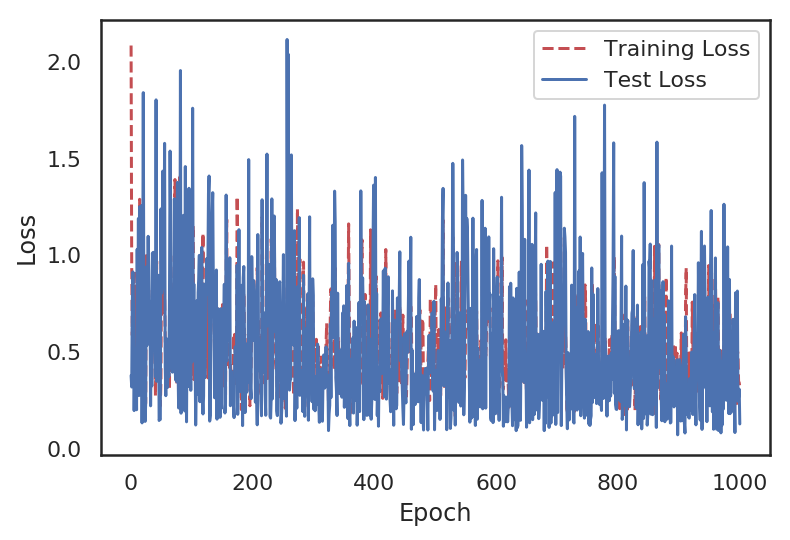

In [45]:
# Get training and test loss histories
training_loss = history.history['loss']
test_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show();

Here we see that loss varys a lot but consistently kepps coming down

In [46]:
test.iat[0,8]-predictions[0]

array([-0.29917145], dtype=float32)

In [47]:
i=0
avg=0
while i < len(predictions):
    mse=(test.iat[i,8]-predictions[i])**2
    #print(mse)
    avg=avg+mse
    i=i+1
print(avg/i)
print((avg/i)/df.strength.mean()*100)
print ("% of error. The avg error divided by the average strength")


[0.02485054]
[0.0693801]
% of error. The avg error divided by the average strength


No handles with labels found to put in legend.


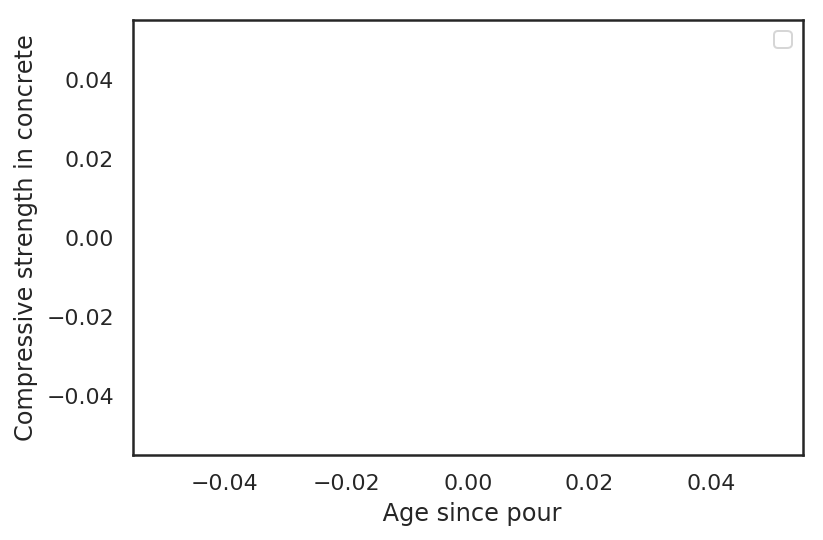

In [58]:

df3 = pd.DataFrame()
df3['Age'] = np.linspace(0, 200)
df3['Age2']=df2['Age']**2
df3['Fly_Ash']=55
df3['Water']=180
df3['Cement']=280

df3['Coarse'] = 970
df3['Fine']=780
df3['Superplasticizer']=6
df3['Slag']=70

results = model.fit()
predictions = NN_model.predict(df3)
plt.plot(df3['Age'], predictions)

plt.xlabel(' Age since pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();


In [49]:
df.Slag.max()

359.4

No handles with labels found to put in legend.


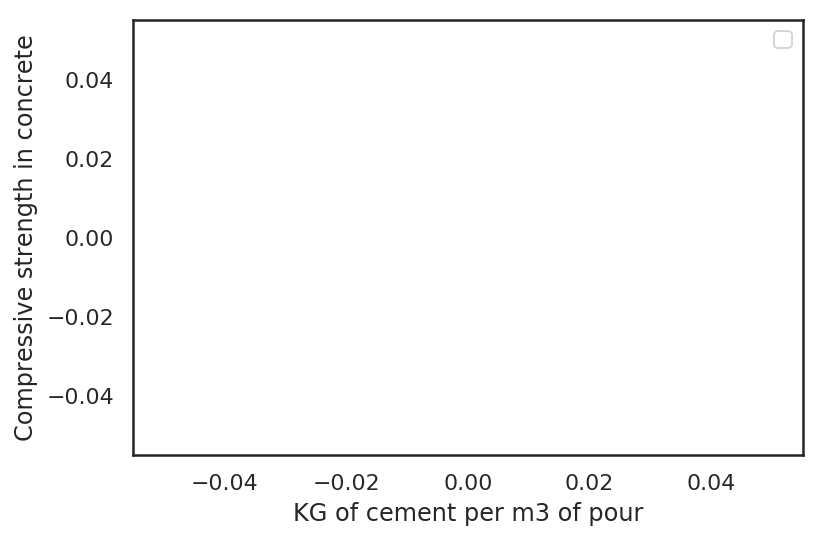

In [57]:

df2 = pd.DataFrame()
df2['Age'] = 100
df2['Age2']=10000
df2['Fly_Ash']=55
df2['Water']=180
df2['Cement']=np.linspace(0, 400)

df2['Coarse'] = 970
df2['Fine']=780
df2['Superplasticizer']=6
df2['Slag']=70

results = model.fit()
predictions = NN_model.predict(df2)
plt.plot(df2['Cement'], predictions)

plt.xlabel('KG of cement per m3 of pour')
plt.ylabel('Compressive strength in concrete')
plt.legend();
